# Companies sentiment analysis on Twitter
We can leverage messages posted on Twitter and other social medias in order to know if there is currently a negative or positive sentiment over a specific subject. Sentiment analysis over a given subject can be used in various domains including trading, public opinion about a policy or a companie.

This mini-project aims to analyse global sentiment about a given companie or subject on Twitter using twitter library tweepy and language processing libraries nltk and textblob.
Nltk and textblob provide pre-trained models for sentiment analysis and diverse language tools from sentence tokenization to stemming.

In [2]:
import tweepy
import re
import pandas as pd
import requests
import json
from textblob import TextBlob
import nltk
from googletrans import Translator
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

## 1 - Data loading and cleaning

#### Fetching the tweets
We connect to the twitter API with a `bearer_token` and fetch the tweets, their context_annotations and the author_ids. Notice that in the query we exclude the retweets (`-is:retweet`) and filter to get only tweets in english (`lang:en`).

Then each tweets is put in a pandas `DataFrame`

In [4]:
# Read the bearer_token in local file
keys = pd.read_csv("keys.csv", index_col = "Type")
bearer_token = keys.loc["Bearer Token", "Value"]

def fetch_tweets(max_results = 100, companie = "Boeing"):
    """
        pull recent tweets about a given subject
        
        max_results: maximum of tweets to pull
        companie: subject of the tweets to pull
    """
    # Connect to the API with the bearer token
    client = tweepy.Client(bearer_token = bearer_token)

    # Query only tweets in english and exclude retweets
    companie = companie.lower()
    query = companie + ' -is:retweet lang:en'

    # pull the tweets
    tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'author_id'], max_results = max_results)
    
    # set the tweets in an array
    array = []
    for tweet in tweets.data:
        array.append([tweet.text, str(tweet.author_id), tweet.context_annotations])
    
    # convert the tweet array to a panda dataframe
    df = pd.DataFrame(array, columns = ["Text", "Author_id", "Annotations"])
    
    return df

# fetch a maximum of 100 tweets about the subject: Boeing
tweets = fetch_tweets(100, "Boeing")

#### Data cleaning

As seen above, tweets can contain usernames (starting with @) and links which are useless for sentiment analysis. Therefore we need to perform some cleaning before retrieving sentiments. We also wish to remove any punctuation and parenthesis )(?.;

In [5]:
def clean_tweet(tweet):
    """
    clean a single tweet text (set to lower case, remove links, remove user tags and punctuation)
    
    tweet: tweet to clean
    """
    # lower case
    tweet = tweet.lower()
    
    # remove links
    tweet = re.sub(r"https://\S+|http://\S", "", tweet)
    
    # remove user tags
    tweet = re.sub(r"@\S+", "", tweet)
    
    # remove any punctuation
    tweet = re.sub(r'[^A-Za-z0-9\s-]', "", tweet)
    
    return tweet

def clean_tweets(tweets):
    """
    copies the dataframe provided and clean the text of every tweet in a new panda dataframe
    
    tweets: panda dataframe where the text need to be cleaned
        (require Text column)
    """
    cleaned_tweets = tweets.copy()
    cleaned_tweets["Text"] = tweets["Text"].apply(lambda x: clean_tweet(x))
    return cleaned_tweets

# cleans the tweets
cleaned_tweets = clean_tweets(tweets)
cleaned_tweets.head()

,Text,Author_id,Annotations
0,small number of boeing staff in chinas tianjin...,2344114254,"[{'domain': {'id': '46', 'name': 'Brand Catego..."
1,ual52 n672ua boeing 767 322erw united airlines...,1306316999585394698,"[{'domain': {'id': '45', 'name': 'Brand Vertic..."
2,small number of boeing staff in chinas tianjin...,1333283589291601923,"[{'domain': {'id': '47', 'name': 'Brand', 'des..."
3,\ng-bmra \ndhk2134 \ndhl air uk \nunited kingd...,1404071707296534537,"[{'domain': {'id': '3', 'name': 'TV Shows', 'd..."
4,foreign military contact in london fir lagr834...,1147646662657097728,"[{'domain': {'id': '47', 'name': 'Brand', 'des..."


## Model predictions (classifying sentiment of tweets)
#### Polarity & Subjectivity
The already optimized model provided by the TextBlob library can extract the polarity and the subjectivity of a given text (respectively in $[-1, 1]$ and $[0, 1]$).
The polarity is the orientation of the sentiment of a text where -1 represents negative sentiment and 1 a positive sentiment, 0 is either neutral or undetermined by the model.
The subjectivity quantifies the proportion of facts or personal sentiment in a text, the higher the subjectivity, the higher the proportion of personal sentiments.
\
\
\
For our mini-project we're only interested in sentiment analysis, therefore we provide the `classify` method which will classify a polarity of $0\pm0.01$ as Untertermined, a polarity less than -0.01 as negative and a polarity more than 0.01 as positive.

In [6]:
def classify(polarity):
    if abs(polarity) < 0.01:
        return "Undetermined"
    elif polarity < 0:
        return "Negative"
    elif polarity > 0:
        return "Positive"

#### Tweet classification
For each row in the pandas `DataFrame` we classify the tweets text as positive, negative or undetermined.

In [7]:
def classify_tweets(tweets):
    """
    For each row in tweets we classify the tweets text as positive, negative or undetermined.
    The result of the classification is put in a new column "Polarity"
    
    tweets: tweets to classify
    """
    output = tweets
    for index, tweet in tweets.iterrows():
        # get polarity and subjectivity of the tweet
        text = tweet["Text"]
        sentiment = TextBlob(text).sentiment
        polarity, subjectivity = sentiment.polarity, sentiment.subjectivity
        
        # classify tweet as negative / neutral / positive
        output.loc[index,"Polarity"] = classify(polarity)
    return output


output = classify_tweets(cleaned_tweets)
output.head()

,Text,Author_id,Annotations,Polarity
0,small number of boeing staff in chinas tianjin...,2344114254,"[{'domain': {'id': '46', 'name': 'Brand Catego...",Negative
1,ual52 n672ua boeing 767 322erw united airlines...,1306316999585394698,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",Undetermined
2,small number of boeing staff in chinas tianjin...,1333283589291601923,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",Negative
3,\ng-bmra \ndhk2134 \ndhl air uk \nunited kingd...,1404071707296534537,"[{'domain': {'id': '3', 'name': 'TV Shows', 'd...",Undetermined
4,foreign military contact in london fir lagr834...,1147646662657097728,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",Negative


## 3 - Results visualization & interpretation
#### Undetermined, positive and negative rates
We get the undetermined, positive and negative rates among the pandas `DataFrame` and plot them to get an idea of the global sentiment.

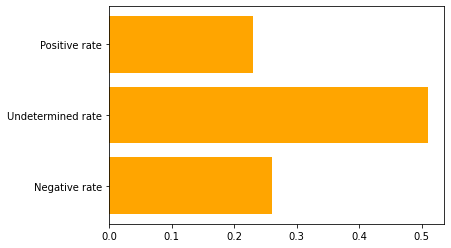

In [8]:
def print_rates(data, plot = False):
    undetermined_nb = 0
    positive_nb = 0
    negative_nb = 0
        
    for index, row in data.iterrows():
        polarity = row["Polarity"]
        if polarity == "Undetermined":
            undetermined_nb += 1
        elif polarity == "Positive":
            positive_nb += 1
        elif polarity == "Negative":
            negative_nb += 1
                
    nb_tweets = len(data)
    pr = positive_nb / nb_tweets
    nr = negative_nb / nb_tweets
    ur = undetermined_nb / nb_tweets
    
    if plot:
        plt.barh(["Negative rate", "Undetermined rate", "Positive rate"], [nr, ur, pr], color = "orange")
        plt.show()
    else:
        print(f"positive rate = {pr} \t negative rate = {nr} "
          +f" \tundetermined rate = {ur}")
    
    return pr, nr, ur
    
print_rates(output, plot = True)
pass

As we can see we have a high undetermined rate which is partly due to the short length of tweets which makes it harder for the model to predict anything. Also undetermined tweets can also be neutral.

We can however see that the negative rate is higher than the positive one which is a good sign for the companie

#### Plotting the frequencies of most common nouns
It can be interesting to plot the frequencies of most common nouns in the text in order to draw some conclusion about which subject might cause a negative impact on the companie or which one might cause a positive one.

In [9]:
def sort_dic_value(dic):
    """
        Sort dic by descending order of its values
        
        dic: dic to sort by descending order of values
    """
    return dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
    
def plot_noun_frequencies(data, color = "grey", nb_plot = 20):
    """
        Plot the frequencies of nb_plot most common nouns in the Text column of data
        
        data: pandas DataFrame, must contain a Text column
        color: color of the horizontal bar plot
        nb_plot: maximum frequencies to plot
    """
    is_noun = lambda pos: pos[:2] == 'NN'
    
    # get occurence of each word
    occurences = {}
    nb_words = 0
    for index, row in data.iterrows():
        text = row["Text"]
        
        # remove each word that isn't a noun
        tokenized = nltk.word_tokenize(text)
        text = ""
        for (word, pos) in nltk.pos_tag(tokenized):
            if is_noun(pos):
                text += " " + word
        
        # put occurences in dictionnary
        for word in text.split():
            nb_words += 1
            occurences[word] = occurences.get(word, 0) + 1
    
    # sort by value
    occurences = sort_dic_value(occurences)
    
    nb_plot = min(nb_plot, len(occurences.keys()))
    
    normalize = lambda values, x: [i / x for i in values]
    
    plt.barh(list(occurences.keys())[:nb_plot], normalize(list(occurences.values())[:nb_plot], nb_words), color = color)
    
    plt.show()

Frequencies of most common nouns in positive tweets


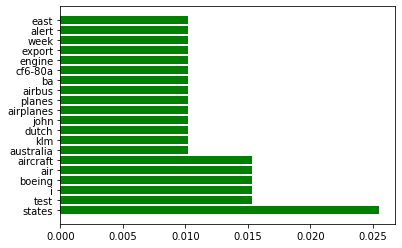

Frequencies of most common nouns in negative tweets


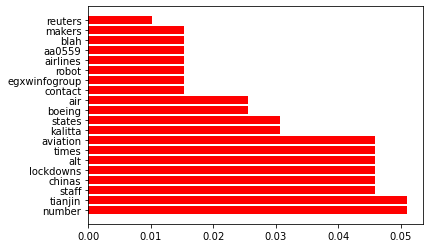

Frequencies of most common nouns in neutral/untermined tweets


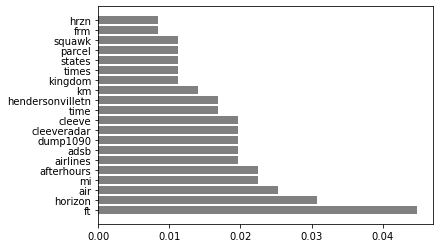

In [10]:
positive_tweets = output[output["Polarity"] == "Positive"]
negative_tweets = output[output["Polarity"] == "Negative"]
undetermined_tweets = output[output["Polarity"] == "Undetermined"]

print("Frequencies of most common nouns in positive tweets")
plot_noun_frequencies(positive_tweets, color = "green")
print("Frequencies of most common nouns in negative tweets")
plot_noun_frequencies(negative_tweets, color = "red")
print("Frequencies of most common nouns in neutral/untermined tweets")
plot_noun_frequencies(undetermined_tweets, color = "grey")

#### Sentence stemming
In order to reduce the undetermined rate over tweets, we try to stem words (that is reduce each word to its root) to facilitate the classifiers job.

In [11]:
def stem(text):
    """
        sem the given text (reduce each word to its root)
    """
    stemmer = PorterStemmer()
    tokenized = word_tokenize(text)
    text = ""
    for word in tokenized:
        text += " " + stemmer.stem(word)
    return text

def classify_tweets_stem(tweets):
    output = tweets
    for index, tweet in tweets.iterrows():
        # get polarity and subjectivity of the tweet
        text = tweet["Text"]
        stemmed_text = stem(text)
        sentiment = TextBlob(stemmed_text).sentiment
        polarity, subjectivity = sentiment.polarity, sentiment.subjectivity
        
        # classify tweet as negative / neutral / positive
        output.loc[index,"Polarity"] = classify(polarity)
    return output

output2 = classify_tweets_stem(cleaned_tweets)
print_rates(output2)

positive rate = 0.21 	 negative rate = 0.27  	undetermined rate = 0.52


(0.21, 0.27, 0.52)

The untermined rate is even higher than before, so our idea fails.

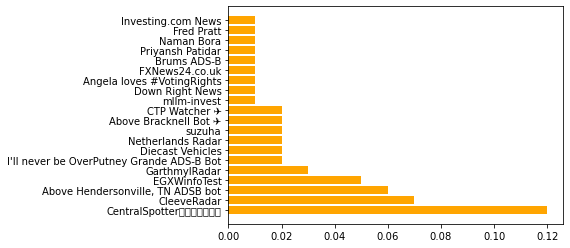

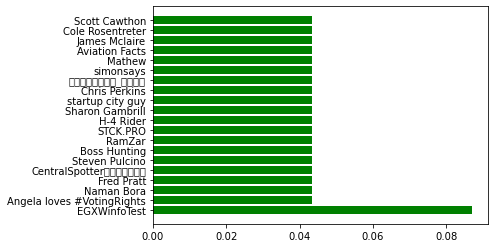

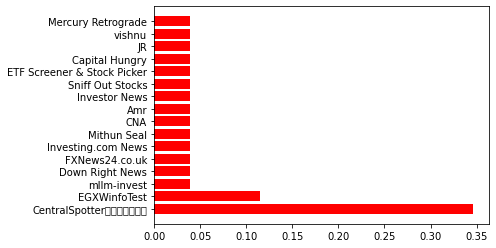

In [12]:
def plot_username_frequencies(data, nb_plot = 20, color = "grey"):
    # get author_id occurences
    occurences = {}
    count = 0
    for index, row in data.iterrows():
        count += 1
        author_id = row["Author_id"]
        occurences[author_id] = occurences.get(author_id, 0) + 1    
    
    # get nb_plot first elements of dic values and keys
    occurences = sort_dic_value(occurences)
    values_slice = list(occurences.values())[:nb_plot]
    keys_slice = list(occurences.keys())[:nb_plot]
    
    # fetch names corresponding to ids
    client = tweepy.Client(bearer_token = bearer_token)
    users = client.get_users(ids = keys_slice).data
    
    names = [user.name for user in users]
    
    # normalize values
    values_slice = [x / count for x in values_slice]
    
    # plot
    plt.rc('axes', unicode_minus=False)
    plt.barh(names, values_slice, color = color)
    plt.show()
    
    
plot_username_frequencies(output, color = "orange")
plot_username_frequencies(positive_tweets, color = "green")
plot_username_frequencies(negative_tweets, color = "red")

positive rate = 0.4 	 negative rate = 0.2  	undetermined rate = 0.4
positive rate = 0.3 	 negative rate = 0.3  	undetermined rate = 0.4
positive rate = 0.5 	 negative rate = 0.2  	undetermined rate = 0.3
positive rate = 0.2 	 negative rate = 0.4  	undetermined rate = 0.4


No handles with labels found to put in legend.


positive rate = 0.7 	 negative rate = 0.2  	undetermined rate = 0.1


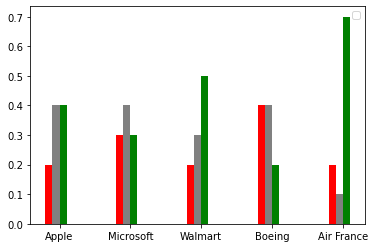

In [13]:
def plot_companies_sentiment():
    companies = ["Apple", "Microsoft", "Walmart", "Boeing", "Air France"]
    positions = [[-0.15, 0.85, 1.85, 2.85, 3.85], 
                 [-0.05, 0.95, 1.95, 2.95, 3.95], 
                 [0.05, 1.05, 2.05, 3.05, 4.05]]
    
    width = 0.1
    
    dic = {"nr": [], "ur": [], "pr": []}
    
    for companie in companies:
        # fetch tweets
        tweets = fetch_tweets(10, companie)
        
        # clean tweets
        cleaned_tweets = clean_tweets(tweets)
        
        # classify tweets
        output = classify_tweets(cleaned_tweets)
        
        pr, nr, ur = print_rates(output)
        dic["nr"].append(nr)
        dic["ur"].append(ur)
        dic["pr"].append(pr)
        
        
    fig, ax = plt.subplots()
    fig.canvas.draw()
    plt.bar(positions[0], dic["nr"], width = width, color = "red")
    plt.bar(positions[1], dic["ur"], width = width, color = "grey")
    plt.bar(positions[2], dic["pr"], width = width, color = "green")
    ax.legend()
    
    companies.insert(0, "Apple")
    ax.set_xticklabels(companies)
    plt.show()

plot_companies_sentiment()